In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import joblib
import os 
import shutil

# Modelling

# Preparation
Prepare both direction 1 and 2 csvs for modelling

Read in files for direction 1 and 2

In [2]:
df_dir_1 = pd.read_csv(
    '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/cleaned/feature_pairwise_cleaned_dir1.csv')
df_dir_2 = pd.read_csv(
    '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/cleaned/feature_pairwise_cleaned_dir2.csv')


Print some descriptors of the data

In [3]:
print("The shape of the direction 1 dataframe is:", df_dir_1.shape)
print("The shape of the direction 2 dataframe is:", df_dir_2.shape)


The shape of the direction 1 dataframe is: (341736, 11)
The shape of the direction 2 dataframe is: (343477, 10)


In [4]:
print("The datatypes in the direction 1 dataframe is:")
print(df_dir_1.dtypes)
print("The datatypes in the direction 2 dataframe is:")
print(df_dir_2.dtypes)


The datatypes in the direction 1 dataframe is:
LINEID              object
PLANNEDTIME_DEP    float64
HOUR                 int64
temp               float64
humidity             int64
wind_speed         float64
weather_id           int64
heavy_precip         int64
TRIPTIME           float64
WEEKDAY              int64
MONTH                int64
dtype: object
The datatypes in the direction 2 dataframe is:
LINEID              object
PLANNEDTIME_DEP    float64
HOUR                 int64
humidity             int64
wind_speed         float64
weather_id           int64
heavy_precip         int64
TRIPTIME           float64
WEEKDAY              int64
MONTH                int64
dtype: object


Check for null values

In [5]:
print("The number of null values in the direction 1 dataframe is: ",
      str(df_dir_1.isna().sum()))
print("The number of null values in the direction 2 dataframe is: ",
      str(df_dir_2.isna().sum()))


The number of null values in the direction 1 dataframe is:  LINEID             0
PLANNEDTIME_DEP    0
HOUR               0
temp               0
humidity           0
wind_speed         0
weather_id         0
heavy_precip       0
TRIPTIME           0
WEEKDAY            0
MONTH              0
dtype: int64
The number of null values in the direction 2 dataframe is:  LINEID             0
PLANNEDTIME_DEP    0
HOUR               0
humidity           0
wind_speed         0
weather_id         0
heavy_precip       0
TRIPTIME           0
WEEKDAY            0
MONTH              0
dtype: int64


Viewing the above column names in each dataframe. Column names should be consistent throughout both direction 1 and 2 dataframes. This is to ensure both dataframes contain the same columns for simplicity when combining with the front-end for feature input.

We can see above that direction 1 differs to direction 2 where it has the column temp. I will remove temp from direction 1 so that both dataframes contain the same features. This will make connecting the model with the frontend to fetch the input variables much easier.

In [6]:
df_dir_1 = df_dir_1.drop(columns=['temp'], axis=1)


In [7]:
print("The columns in direction 1 dataframe are:")
print(df_dir_1.columns)

print("The columns in direction 2 dataframe are:")
print(df_dir_2.columns)


The columns in direction 1 dataframe are:
Index(['LINEID', 'PLANNEDTIME_DEP', 'HOUR', 'humidity', 'wind_speed',
       'weather_id', 'heavy_precip', 'TRIPTIME', 'WEEKDAY', 'MONTH'],
      dtype='object')
The columns in direction 2 dataframe are:
Index(['LINEID', 'PLANNEDTIME_DEP', 'HOUR', 'humidity', 'wind_speed',
       'weather_id', 'heavy_precip', 'TRIPTIME', 'WEEKDAY', 'MONTH'],
      dtype='object')


Remove additional outliers

In [8]:
def remove_outliers(df_dir):

     lines_dir = sorted(list(df_dir['LINEID'].unique()))

     for line in lines_dir:
          # print number of rows in dataframe
          print("Number of rows remaining in dataframe:", str(df_dir.shape[0]))

          df_dir.reset_index(drop=True, inplace=True)
          print("Now doing line", str(line))

          # select all rows with the current line id
          df_selected_line = df_dir.loc[df_dir['LINEID'] == line]

          # get zscores
          line_zscores = np.abs(stats.zscore(df_selected_line['TRIPTIME']))

          # get rows above and below threshold
          rows_above_threshold = np.where(line_zscores > 3)
          rows_below_threshold = np.where(line_zscores < -3)
          # print number of rows
          print("There are", str(len(rows_above_threshold[0])), "row(s) above the threshold, and", str(len(rows_below_threshold[0])), "row(s) below \
               the threshold. ", str(len(rows_above_threshold[0])+len(rows_below_threshold[0])), "row(s) will be dropped from the dataframe")

          # convert to numpy array
          rows_above_threshold = np.asarray(rows_above_threshold)
          rows_below_threshold = np.asarray(rows_below_threshold)

          # drop rows outside of threshold
          df_dir = df_dir.drop(rows_above_threshold.flatten(), axis=0)
          df_dir = df_dir.drop(rows_below_threshold.flatten(), axis=0)
     return df_dir

In [9]:
df_dir_1.shape

(341736, 10)

In [10]:
df_dir_1 = remove_outliers(df_dir_1)

Number of rows remaining in dataframe: 341736
Now doing line 1
There are 4 row(s) above the threshold, and 0 row(s) below                the threshold.  4 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 341732
Now doing line 102
There are 20 row(s) above the threshold, and 0 row(s) below                the threshold.  20 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 341712
Now doing line 104
There are 16 row(s) above the threshold, and 0 row(s) below                the threshold.  16 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 341696
Now doing line 11
There are 121 row(s) above the threshold, and 0 row(s) below                the threshold.  121 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 341575
Now doing line 111
There are 4 row(s) above the threshold, and 0 row(s) below                the threshold.  4 row(s) will be dropped from the dataframe


In [11]:
df_dir_2 = remove_outliers(df_dir_2)

Number of rows remaining in dataframe: 343477
Now doing line 1
There are 21 row(s) above the threshold, and 0 row(s) below                the threshold.  21 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 343456
Now doing line 102
There are 29 row(s) above the threshold, and 0 row(s) below                the threshold.  29 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 343427
Now doing line 104
There are 15 row(s) above the threshold, and 0 row(s) below                the threshold.  15 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 343412
Now doing line 11
There are 31 row(s) above the threshold, and 0 row(s) below                the threshold.  31 row(s) will be dropped from the dataframe
Number of rows remaining in dataframe: 343381
Now doing line 111
There are 79 row(s) above the threshold, and 0 row(s) below                the threshold.  79 row(s) will be dropped from the datafram

In [12]:
df_dir_1.to_csv(
    '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/modelling_ready_dir1.csv', index=False)
df_dir_2.to_csv(
    '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/modelling_ready_dir2.csv', index=False)


# 1.1 Test-train-split

Set up test-train-split for modelling

In [13]:
def get_split(df_line):

    # shuffle data frame code from 'sample_solution_COMP47350_Task2_PredictiveModeling_Evaluation_CreditRiskPrediction.ipynb'
    # randomly generate sequence based on dataframe index and set to be new index
    df_line.set_index(np.random.permutation(df_line.index))
    # sort the resulting random index
    df_line.sort_index(inplace=True)

    # drop unneeded columns
    df_line.drop(columns=['LINEID'], inplace=True)

    X = df_line.drop(columns=["TRIPTIME"], axis=1)
    y = pd.DataFrame(df_line['TRIPTIME'])

    # do test train split
    # Split the dataset into two datasets, 80% training and 20% test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1)

    return X_train, y_train, X_test, y_test


In [14]:
def train_test_dicts(df_dir):
    # create directory with all the lines of a direction
    lines_dir = sorted(list(df_dir['LINEID'].unique()))
    
    # Make dictionaries where the keys will store the training and test dataframes for each line
    # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
    X_train_dict = {}
    y_train_dict = {}
    X_test_dict = {}
    y_test_dict = {}

    # list to append low value samples
    lines_to_drop = []

    # iterate through lines
    for line in lines_dir:

        # dataframe containing only rows with current lineid
        df_line = df_dir.loc[df_dir['LINEID'] == line]

        # check for df with low values (where accurate predictions will not be possible as any one value will have too much influence on the overall model outcome)
        if df_line.shape[0] < 5:
            print('Not enough values for line', str(line))
            lines_to_drop.append(line)
            
        else:
            # get train test split
            split = get_split(df_line)

            # assign function return values to dicts
            X_train_dict[line] = split[0]
            y_train_dict[line] = split[1]
            X_test_dict[line] = split[2]
            y_test_dict[line] = split[3]

            # reset indexes so each line will adhere to the correct dataframe
            X_train_dict[line].reset_index(drop=True, inplace=True)
            y_train_dict[line].reset_index(drop=True, inplace=True)
            X_test_dict[line].reset_index(drop=True, inplace=True)
            y_test_dict[line].reset_index(drop=True, inplace=True)

    # https://stackoverflow.com/questions/4211209/remove-all-the-elements-that-occur-in-one-list-from-another
    lines_dir = [x for x in lines_dir if x not in lines_to_drop]
    
    return lines_dir, X_train_dict, y_train_dict, X_test_dict, y_test_dict


# Direction 1
When tried first on a linear regression model, we were receiving low accuracy with $r^2$ values below 0.2. We then switched to a Random Forest Regressor (RFR) model, which was proving to be a better fit for the data.

We began the RFR with all features (both medium and high information gain), and omitted features step by step in order to find the highest performing model that would give the most accuracy. Below is the code for this model.

## 1.2 Linear Regression

Create a pickle file containing the prediction model for each line.

In [47]:
def get_lr_model_dict(direction, lines_dir, X_train_dict, y_train_dict):
    
    lr_model_dict = {}
    
    for line in lines_dir:
        print(f'Line {line}')
        
        # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
        X_train = X_train_dict[line]
        y_train = y_train_dict[line]
    
        lr = LinearRegression()
        lr_model_dict[line] = lr.fit(X_train, y_train)

        # code from https://stackoverflow.com/questions/11660605/how-to-overwrite-a-folder-if-it-already-exists-when-creating-it-with-makedirs
        dir = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/linreg/joblibfiles/line_{line}_model/dir{direction}'
        if os.path.exists(dir):
            shutil.rmtree(dir)
        os.makedirs(dir)

        # save the model to a joblib file
        filename = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/linreg/joblibfiles/line_{line}_model/dir{direction}/line_{line}_lr.joblib'
        joblib.dump(lr_model_dict[line], open(filename, 'wb'))

    return lr_model_dict

Print some metrics evaluating the prediciton models performance.

In [43]:
def get_lr_metric_lists(direction, lines_dir, lr_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict):
    # sum for averages
    train_mae_sum = 0
    train_mape_sum = 0
    train_rmse_sum = 0
    train_r2_sum = 0

    test_mae_sum = 0
    test_mape_sum = 0
    test_rsme_sum = 0
    test_r2_sum = 0

    train_metric_list = []
    test_metric_list = []

    for line in lines_dir:
        # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
        # training data
        X_train = X_train_dict[line]
        y_train = y_train_dict[line]
        # test data
        X_test = X_test_dict[line]
        y_test = y_test_dict[line]
        lr = lr_model_dict[line]

        lr_predictions_train = list(lr.predict(X_train))
        lr_predictions_test = list(lr.predict(X_test))

        # choice of metrics from https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56 and
        # https://towardsdatascience.com/random-forest-regression-5f605132d19d
        train_mae = metrics.mean_absolute_error(y_train, lr_predictions_train)
        train_mape = metrics.mean_absolute_percentage_error(
            y_train, lr_predictions_train)
        train_rmse = math.sqrt(metrics.mean_squared_error(y_train,
        lr_predictions_train))
        train_r2 = metrics.r2_score(
            y_train, lr_predictions_train) 

        test_mae = metrics.mean_absolute_error(y_test, lr_predictions_test)
        test_mape = metrics.mean_absolute_percentage_error(
            y_test, lr_predictions_test)
        test_rmse = math.sqrt(metrics.mean_squared_error(y_test,
        lr_predictions_test))
        test_r2 = metrics.r2_score(y_test, lr_predictions_test)

        print(f"Test MAE for line {line}: {test_mae}")
        print(f"Test R2 for line {line}: {test_r2}")


        with open(f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/linreg/joblibfiles/line_{line}_model/dir{direction}/line_{line}_lr_metrics.csv', 'w') as file:
            file.write(f'\nTrain metrics for line {line}:'
                       f'\nMAE: {round(train_mae, 5)}' +
                       f'\nMAPE: {round(train_mape,5)}' +
                       f'\nMSE: {round(train_rmse,5)}'+
                       f'\nR2: {round(train_r2,5)}' +
                       f'\nTest metrics for line {line}:'
                       f'\nMAE: {round(test_mae,5)}' +
                       f'\nMAPE: {round(test_mape,5)}' +
                       f'\nMSE: {round(test_rmse,5)}'+
                       f'\nR2: {round(test_r2,5)}')

        # sum for averages
        train_mae_sum += train_mae
        train_mape_sum += train_mape
        train_rmse_sum += train_rmse
        train_r2_sum += train_r2

        test_mae_sum += test_mae
        test_mape_sum += test_mape
        test_rsme_sum += test_rmse
        test_r2_sum += test_r2

    train_metric_list.append(
        [train_mae_sum, train_mape_sum, train_rmse_sum, train_r2_sum])
    test_metric_list.append(
        [test_mae_sum, test_mape_sum, train_rmse_sum, test_r2_sum])

    return train_metric_list, test_metric_list


## 1.3 Random Forest
### 1.3.1 Create the model
The random forest model works on the same test-train-splits as above. This next cell creates a prediction model for each line and dumps the model into a pickle file. Improved through https://www.keboola.com/blog/random-forest-regression

In [15]:
def get_rfr_model_dict(direction, lines_dir, X_train_dict, y_train_dict):
    
    rf_model_dict = {}

    for line in lines_dir:
        print(f'Line {line}')

        # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
        X_train = X_train_dict[line]
        y_train = y_train_dict[line]

        rfr = RandomForestRegressor(oob_score=True, random_state=1, n_estimators=50, max_depth=50)
        rf_model_dict[line] = rfr.fit(X_train, y_train)
        
        # code from https://stackoverflow.com/questions/11660605/how-to-overwrite-a-folder-if-it-already-exists-when-creating-it-with-makedirs

        dir = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/joblibfiles/line_{line}_model/dir{direction}'
        if os.path.exists(dir):
            shutil.rmtree(dir)
        os.makedirs(dir)

        # save the model to a joblib file
        filename = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/joblibfiles/line_{line}_model/dir{direction}/line_{line}_rfr.joblib'
        joblib.dump(rf_model_dict[line], open(filename, 'wb'))

    return rf_model_dict

Print metrics for each line into accompanying files outling the prediction model's performance.

In [16]:
def get_rf_metric_lists(direction, lines_dir, rf_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict):
    # sum for averages
    train_mae_sum = 0
    train_mape_sum = 0
    train_rmse_sum = 0
    train_r2_sum = 0

    test_mae_sum = 0
    test_mape_sum = 0
    test_rmse_sum = 0
    test_r2_sum = 0

    train_metric_list = []
    test_metric_list = []

    for line in lines_dir:
        # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
        # training data
        X_train = X_train_dict[line]
        y_train = y_train_dict[line]
        # test data
        X_test = X_test_dict[line]
        y_test = y_test_dict[line]
        rfr = rf_model_dict[line]

        rfr_predictions_train = list(rfr.predict(X_train))
        rfr_predictions_test = list(rfr.predict(X_test))

        # choice of metrics from https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56 and
        # https://towardsdatascience.com/random-forest-regression-5f605132d19d
        train_mae = metrics.mean_absolute_error(y_train, rfr_predictions_train)
        train_mape = metrics.mean_absolute_percentage_error(
            y_train, rfr_predictions_train)
        train_rmse = math.sqrt(metrics.mean_squared_error(y_train,
        rfr_predictions_train))
        train_r2 = metrics.r2_score(
            y_train, rfr_predictions_train) 

        test_mae = metrics.mean_absolute_error(y_test, rfr_predictions_test)
        test_mape = metrics.mean_absolute_percentage_error(
            y_test, rfr_predictions_test)
        test_rmse = math.sqrt(metrics.mean_squared_error(y_test,
        rfr_predictions_test))
        test_r2 = metrics.r2_score(y_test, rfr_predictions_test)

        print(f"Test MAE for line {line}: {round(test_mae,5)}")
        print(f"Test R2 for line {line}: {round(test_r2,5)}")

        with open(f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/joblibfiles/line_{line}_model/dir{direction}/line_{line}_rfr_metrics.csv', 'w') as file:
            file.write(f'\nTrain metrics for line {line}:'
                       f'\nMAE: {round(train_mae, 5)}' +
                       f'\nMAPE: {round(train_mape,5)}' +
                       f'\nMSE: {round(train_rmse,5)}'+
                       f'\nR2: {round(train_r2,5)}' +
                       f'\nTest metrics for line {line}:'
                       f'\nMAE: {round(test_mae,5)}' +
                       f'\nMAPE: {round(test_mape,5)}' +
                       f'\nMSE: {round(test_rmse,5)}'+
                       f'\nR2: {round(test_r2,5)}')

        # sum for averages
        train_mae_sum += train_mae
        train_mape_sum += train_mape
        train_rmse_sum += train_rmse
        train_r2_sum += train_r2

        test_mae_sum += test_mae
        test_mape_sum += test_mape
        test_rmse_sum += test_rmse
        test_r2_sum += test_r2

    train_metric_list.append(
        [train_mae_sum, train_mape_sum, train_rmse_sum, train_r2_sum])
    test_metric_list.append(
        [test_mae_sum, test_mape_sum, test_rmse_sum, test_r2_sum])

    return train_metric_list, test_metric_list


## 1.4 Nearest Neighbour Regression
We have already determined the Random Forest Regressor to have a mean actual error score of 349.35 seconds and a mean actual percentage error score of 7.6%. To determine if our model can improve, we will now use a K Nearest Neighbour modelling algorithm on our data.

In [37]:
def get_knn_model_dict(direction, lines_dir, X_train_dict, y_train_dict):
    
    knn_model_dict = {}

    for line in lines_dir:
        print(f'Line {line}')
        
        # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
        X_train = X_train_dict[line]
        y_train = y_train_dict[line]

        k=5

        knn = KNeighborsRegressor(n_neighbors=k)
        knn_model_dict[line] = knn.fit(X_train, y_train)

        # code from https://stackoverflow.com/questions/11660605/how-to-overwrite-a-folder-if-it-already-exists-when-creating-it-with-makedirs

        dir = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/knn/joblibfiles/line_{line}_model/dir{direction}'
        if os.path.exists(dir):
            shutil.rmtree(dir)
        os.makedirs(dir)

        # save the model to a joblib file
        filename = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/knn/joblibfiles/line_{line}_model/dir{direction}/line_{line}_knn.joblib'
        joblib.dump(knn_model_dict[line], open(filename, 'wb'))

    return knn_model_dict

Print some metrics evaluating the prediciton models performance.

In [38]:
def get_knn_metric_lists(direction, lines_dir, knn_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict):
     # sum for averages
    train_mae_sum = 0
    train_mape_sum = 0
    train_rmse_sum = 0
    train_r2_sum = 0

    test_mae_sum = 0
    test_mape_sum = 0
    test_rmse_sum = 0
    test_r2_sum = 0

    train_metric_list = []
    test_metric_list = []
    
    for line in lines_dir:
        
        # Code adapted from https://github.com/jamie-reynolds-UCD/UCD-Dublin-Bus-App-Team9/blob/main/data/General_Files_Linreg/general_LinRegModelling.ipynb
        # training data
        X_train = X_train_dict[line]
        y_train = y_train_dict[line]
        # test data
        X_test = X_test_dict[line]
        y_test = y_test_dict[line]
        knn = knn_model_dict[line]

        knn_predictions_train = list(knn.predict(X_train))
        knn_predictions_test = list(knn.predict(X_test))
        # https://towardsdatascience.com/random-forest-regression-5f605132d19d
        # should be as close to 0 as possible (percentage error)
        train_mae = metrics.mean_absolute_error(y_train, knn_predictions_train)
        train_mape = metrics.mean_absolute_percentage_error(
            y_train, knn_predictions_train)
        train_rmse = math.sqrt(metrics.mean_squared_error(y_train,
        knn_predictions_train))
        train_r2 = metrics.r2_score(
            y_train, knn_predictions_train) 

        test_mae = metrics.mean_absolute_error(y_test, knn_predictions_test)
        test_mape = metrics.mean_absolute_percentage_error(
            y_test, knn_predictions_test)
        test_rmse = math.sqrt(metrics.mean_squared_error(y_test,
        knn_predictions_test))
        test_r2 = metrics.r2_score(y_test, knn_predictions_test)

        print(f"Test MAE for line {line}: {round(test_mae,5)}")
        print(f"Test R2 for line {line}: {round(test_r2,5)}")

        with open(f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/knn/joblibfiles/line_{line}_model/dir{direction}/line_{line}_knn_metrics.csv', 'w') as file:
            file.write(f'\nTrain metrics for line {line}:'
                       f'\nMAE: {round(train_mae, 5)}' +
                       f'\nMAPE: {round(train_mape,5)}' +
                       f'\nMSE: {round(train_rmse,5)}'+
                       f'\nR2: {round(train_r2,5)}' +
                       f'\nTest metrics for line {line}:'
                       f'\nMAE: {round(test_mae,5)}' +
                       f'\nMAPE: {round(test_mape,5)}' +
                       f'\nMSE: {round(test_rmse,5)}'+
                       f'\nR2: {round(test_r2,5)}')
        # sum for averages
        train_mae_sum += train_mae
        train_mape_sum += train_mape
        train_rmse_sum += train_rmse
        train_r2_sum += train_r2

        test_mae_sum += test_mae
        test_mape_sum += test_mape
        test_rmse_sum += test_rmse
        test_r2_sum += test_r2

    train_metric_list.append(
        [train_mae_sum, train_mape_sum, train_rmse_sum, train_r2_sum])
    test_metric_list.append(
        [test_mae_sum, test_mape_sum, test_rmse_sum, test_r2_sum])


    return train_metric_list, test_metric_list


## Print metrics
Print the average score for each metric:


In [17]:
def print_metrics(lines_dir, train_metric_list, test_metric_list):
    print("============Train metrics=============")
    print("Mean MAE:", str(round(train_metric_list[0]/len(lines_dir),5)))
    print("Mean MAPE:", str(round(train_metric_list[1]/len(lines_dir),5)))    
    print("Mean RMSE:", str(round(train_metric_list[2]/len(lines_dir),5)))
    print("Mean R2:", str(round(train_metric_list[3]/len(lines_dir),5)))

    print("============Test metrics=============")
    print("Mean MAE:", str(round(test_metric_list[0]/len(lines_dir),5)))
    print("Mean MAPE:", str(round(test_metric_list[1]/len(lines_dir),5)))
    print("Mean RMSE:", str(round(test_metric_list[2]/len(lines_dir),5)))
    print("Mean R2:", str(round(test_metric_list[3]/len(lines_dir),5)))


# 2 Run the algorithm

In [21]:
df_dir_1 = pd.read_csv(
    '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/modelling_ready_dir1.csv')

Drop features negatively impacting model performance

In [22]:
df_dir_1 = df_dir_1.drop(columns=['heavy_precip','HOUR','weather_id'])


1. Set up test train split

In [23]:
return_func_1 = train_test_dicts(df_dir_1)

Not enough values for line 33E
Not enough values for line 41D


We can see the lines with less than 5 rows are 41D and 33E. We will therefore omit these lines from modelling.

In [24]:
lines_dir = return_func_1[0]
X_train_dict = return_func_1[1]
y_train_dict = return_func_1[2]
X_test_dict = return_func_1[3]
y_test_dict = return_func_1[4]

### 2.1. Linear Regression

In [41]:
lr_model_dict = get_lr_model_dict(1,lines_dir, X_train_dict, y_train_dict)

Line 1
Line 102
Line 104
Line 11
Line 111
Line 114
Line 116
Line 120
Line 122
Line 123
Line 13
Line 130
Line 14
Line 140
Line 142
Line 145
Line 14C
Line 15
Line 150
Line 151
Line 15A
Line 15B
Line 15D
Line 16
Line 161
Line 16C
Line 16D
Line 17
Line 17A
Line 18
Line 184
Line 185
Line 220
Line 236
Line 238
Line 239
Line 25
Line 25A
Line 25B
Line 25D
Line 25X
Line 26
Line 27
Line 270
Line 27A
Line 27B
Line 27X
Line 29A
Line 31
Line 31A
Line 31B
Line 31D
Line 32
Line 32X
Line 33
Line 33A
Line 33B
Line 33D
Line 33X
Line 37
Line 38
Line 38A
Line 38B
Line 38D
Line 39
Line 39A
Line 39X
Line 4
Line 40
Line 40B
Line 40D
Line 40E
Line 41
Line 41B
Line 41C
Line 41X
Line 42
Line 42D
Line 43
Line 44
Line 44B
Line 45A
Line 46A
Line 47
Line 49
Line 51D
Line 53
Line 54A
Line 56A
Line 59
Line 61
Line 63
Line 65
Line 65B
Line 66
Line 66A
Line 66B
Line 66X
Line 67
Line 67X
Line 68
Line 68A
Line 69
Line 69X
Line 7
Line 70
Line 70D
Line 75
Line 76
Line 76A
Line 77A
Line 79
Line 79A
Line 7A
Line 7B
Line 7D
L

In [44]:
lr_metric_list = get_lr_metric_lists(1, lines_dir, lr_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict)

Test MAE for line 1: 549.5114886629814
Test R2 for line 1: 0.11127554415422014
Test MAE for line 102: 377.8564500252702
Test R2 for line 102: 0.10521499968097614
Test MAE for line 104: 318.8079602257134
Test R2 for line 104: 0.03259479262658038
Test MAE for line 11: 950.8127336349991
Test R2 for line 11: 0.22117224170748173
Test MAE for line 111: 324.2194997068346
Test R2 for line 111: 0.1474337654995891
Test MAE for line 114: 295.93849652283143
Test R2 for line 114: 0.12164092809792815
Test MAE for line 116: 496.91596205952555
Test R2 for line 116: 0.2095167427170298
Test MAE for line 120: 318.0582015591437
Test R2 for line 120: 0.05477289260488993
Test MAE for line 122: 536.9010961849741
Test R2 for line 122: 0.14790737537762466
Test MAE for line 123: 483.36507297238575
Test R2 for line 123: 0.11748394020447983
Test MAE for line 13: 753.4667088199775
Test R2 for line 13: 0.14789458377753606
Test MAE for line 130: 219.6425843698365
Test R2 for line 130: 0.14113105168695173
Test MAE fo

In [45]:
lr_train_metric_list = lr_metric_list[0][0]
lr_test_metric_list = lr_metric_list[1][0]

In [46]:
print("LR")
print_metrics(lines_dir, lr_train_metric_list, lr_test_metric_list)

LR
============Train metrics=============
Mean MAE: 480.45913
Mean MAPE: 0.15044
Mean RMSE: 632.94276
Mean R2: 0.1384
============Test metrics=============
Mean MAE: 482.60534
Mean MAPE: 0.15122
Mean RMSE: 632.94276
Mean R2: 0.0903


### 2.2 Random Forest

In [25]:
rf_model_dict = get_rfr_model_dict(1,lines_dir, X_train_dict, y_train_dict)

Line 1
Line 102
Line 104
Line 11
Line 111
Line 114
Line 116
Line 120
Line 122
Line 123
Line 13
Line 130
Line 14
Line 140
Line 142
Line 145
Line 14C
Line 15
Line 150
Line 151
Line 15A
Line 15B
Line 15D
Line 16
Line 161
Line 16C
Line 16D
Line 17
Line 17A
Line 18
Line 184
Line 185
Line 220
Line 236
Line 238
Line 239
Line 25
Line 25A
Line 25B
Line 25D
Line 25X
Line 26
Line 27
Line 270
Line 27A
Line 27B
Line 27X
Line 29A
Line 31
Line 31A
Line 31B
Line 31D
Line 32
Line 32X
Line 33
Line 33A
Line 33B
Line 33D
Line 33X
Line 37
Line 38
Line 38A
Line 38B
Line 38D
Line 39
Line 39A
Line 39X
Line 4
Line 40
Line 40B
Line 40D
Line 40E
Line 41
Line 41B
Line 41C
Line 41X
Line 42
Line 42D
Line 43
Line 44
Line 44B
Line 45A
Line 46A
Line 47
Line 49
Line 51D
Line 53
Line 54A
Line 56A
Line 59
Line 61
Line 63
Line 65
Line 65B
Line 66
Line 66A
Line 66B
Line 66X
Line 67
Line 67X
Line 68
Line 68A
Line 69
Line 69X
Line 7
Line 70
Line 70D
Line 75
Line 76
Line 76A
Line 77A
Line 79
Line 79A
Line 7A
Line 7B
Line 7D
L

In [26]:
rf_metric_list = get_rf_metric_lists(1, lines_dir, rf_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict)

Test MAE for line 1: 256.74993
Test R2 for line 1: 0.7758
Test MAE for line 102: 279.29372
Test R2 for line 102: 0.48453
Test MAE for line 104: 239.64213
Test R2 for line 104: 0.2576
Test MAE for line 11: 233.90849
Test R2 for line 11: 0.89977
Test MAE for line 111: 222.46695
Test R2 for line 111: 0.48866
Test MAE for line 114: 192.25475
Test R2 for line 114: 0.64158
Test MAE for line 116: 329.55333
Test R2 for line 116: 0.67747
Test MAE for line 120: 239.90238
Test R2 for line 120: 0.4217
Test MAE for line 122: 303.85208
Test R2 for line 122: 0.74326
Test MAE for line 123: 315.72929
Test R2 for line 123: 0.6118
Test MAE for line 13: 462.16038
Test R2 for line 13: 0.70471
Test MAE for line 130: 150.67152
Test R2 for line 130: 0.57766
Test MAE for line 14: 380.9565
Test R2 for line 14: 0.60754
Test MAE for line 140: 273.68497
Test R2 for line 140: 0.65221
Test MAE for line 142: 172.49875
Test R2 for line 142: 0.98598
Test MAE for line 145: 430.51794
Test R2 for line 145: 0.55352
Test MA

In [143]:
rf_train_metric_list = rf_metric_list[0][0]
rf_test_metric_list = rf_metric_list[1][0]

In [144]:
print("RFR")
print_metrics(lines_dir, rf_train_metric_list, rf_test_metric_list)

RFR
============Train metrics=============
Mean MAE: 123.05487
Mean MAPE: 0.03648
Mean RMSE: 178.62459
Mean R2: 0.91963
============Test metrics=============
Mean MAE: 322.04377
Mean MAPE: 0.09495
Mean RMSE: 447.25074
Mean R2: 0.45489


In [54]:
importance = pd.DataFrame(
    {'feature': X_train_dict['46A'].columns, 'importance': rf_model_dict['46A'].feature_importances_})
importance.sort_values('importance', ascending=False)


,feature,importance
2,PLANNEDTIME_DEP,0.660028
3,WEEKDAY,0.115647
1,wind_speed,0.080590
0,humidity,0.078224
4,MONTH,0.065511


### 2.3 KNN

In [56]:
knn_model_dict = get_knn_model_dict(1,lines_dir, X_train_dict, y_train_dict)

Line 1
Line 102
Line 104
Line 11
Line 111
Line 114
Line 116
Line 120
Line 122
Line 123
Line 13
Line 130
Line 14
Line 140
Line 142
Line 145
Line 14C
Line 15
Line 150
Line 151
Line 15A
Line 15B
Line 15D
Line 16
Line 161
Line 16C
Line 16D
Line 17
Line 17A
Line 18
Line 184
Line 185
Line 220
Line 236
Line 238
Line 239
Line 25
Line 25A
Line 25B
Line 25D
Line 25X
Line 26
Line 27
Line 270
Line 27A
Line 27B
Line 27X
Line 29A
Line 31
Line 31A
Line 31B
Line 31D
Line 32
Line 32X
Line 33
Line 33A
Line 33B
Line 33D
Line 33X
Line 37
Line 38
Line 38A
Line 38B
Line 38D
Line 39
Line 39A
Line 39X
Line 4
Line 40
Line 40B
Line 40D
Line 40E
Line 41
Line 41B
Line 41C
Line 41X
Line 42
Line 42D
Line 43
Line 44
Line 44B
Line 45A
Line 46A
Line 47
Line 49
Line 51D
Line 53
Line 54A
Line 56A
Line 59
Line 61
Line 63
Line 65
Line 65B
Line 66
Line 66A
Line 66B
Line 66X
Line 67
Line 67X
Line 68
Line 68A
Line 69
Line 69X
Line 7
Line 70
Line 70D
Line 75
Line 76
Line 76A
Line 77A
Line 79
Line 79A
Line 7A
Line 7B
Line 7D
L

In [57]:
knn_metric_list = get_knn_metric_lists(1, lines_dir, knn_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict)

Test MAE for line 1: 309.86826
Test R2 for line 1: 0.65833
Test MAE for line 102: 320.10704
Test R2 for line 102: 0.30847
Test MAE for line 104: 305.67838
Test R2 for line 104: 0.02179
Test MAE for line 11: 428.40938
Test R2 for line 11: 0.75664
Test MAE for line 111: 231.15649
Test R2 for line 111: 0.50983
Test MAE for line 114: 237.8392
Test R2 for line 114: 0.40663
Test MAE for line 116: 540.64444
Test R2 for line 116: -0.26877
Test MAE for line 120: 249.53226
Test R2 for line 120: 0.47701
Test MAE for line 122: 381.87556
Test R2 for line 122: 0.58162
Test MAE for line 123: 365.26671
Test R2 for line 123: 0.48071
Test MAE for line 13: 511.38614
Test R2 for line 13: 0.64052
Test MAE for line 130: 165.84529
Test R2 for line 130: 0.49743
Test MAE for line 14: 489.93063
Test R2 for line 14: 0.37071
Test MAE for line 140: 334.81599
Test R2 for line 140: 0.48347
Test MAE for line 142: 238.69028
Test R2 for line 142: 0.97415
Test MAE for line 145: 495.30434
Test R2 for line 145: 0.47973
Te

3. Print results

In [58]:
knn_train_metric_list = knn_metric_list[0][0]
knn_test_metric_list = knn_metric_list[1][0]

In [59]:
print("KNN")
print_metrics(lines_dir, knn_train_metric_list, knn_test_metric_list)

KNN
============Train metrics=============
Mean MAE: 303.14146
Mean MAPE: 0.08879
Mean RMSE: 419.53417
Mean R2: 0.56868
============Test metrics=============
Mean MAE: 367.20747
Mean MAPE: 0.10772
Mean RMSE: 503.69141
Mean R2: 0.3374


- tried using sqrt of the number of samples in each model, worsened model
https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb
- tried using 15 (optimum according to graph of full dataframe), worsened model

In [60]:
train_rmse = knn_train_metric_list[2]
test_rmse = knn_test_metric_list[2]

Print the order of the most influential features on the model.

In [61]:
line_46A = df_dir_1.loc[df_dir_1['LINEID']=='46A']

In [62]:
split_46A = get_split(line_46A)

In [63]:
X_train = split_46A[0]
y_train = split_46A[1]
X_test = split_46A[2]
y_test = split_46A[3]

Determining optimal k value
https://www.geeksforgeeks.org/ml-implementation-of-knn-classifier-using-sklearn/

In [64]:
K = []
training = []
test = []
scores = {}
  
for k in range(2, 20):
    clf = KNeighborsRegressor(n_neighbors = k)
    clf.fit(X_train, y_train)
  
    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    K.append(k)
  
    training.append(training_score)
    test.append(test_score)
    scores[k] = [training_score, test_score]

In [65]:
for keys, values in scores.items():
    print(keys, ':', values)

2 : [0.8247743651897773, 0.5520900900012412]
3 : [0.7624172535815873, 0.5841735311846717]
4 : [0.7269817498247555, 0.6058087397245178]
5 : [0.7049502024590595, 0.6205839241878449]
6 : [0.6910806865590917, 0.6282471273118516]
7 : [0.6805170288521523, 0.6351237261025495]
8 : [0.6724669110527224, 0.6355513435150595]
9 : [0.6654582143102554, 0.6384480497294267]
10 : [0.6592608677737299, 0.6405359260572292]
11 : [0.6546876760590462, 0.6434393907696105]
12 : [0.6518578103961195, 0.6458090375854453]
13 : [0.648601530108948, 0.6468727820653726]
14 : [0.6457627056892353, 0.6476855961798607]
15 : [0.642530051412574, 0.6487605536980348]
16 : [0.6400384171129396, 0.6476542533695013]
17 : [0.6358190987458437, 0.6462859342372358]
18 : [0.6325907074249288, 0.6456253912515597]
19 : [0.6299663923397039, 0.6444327270069314]


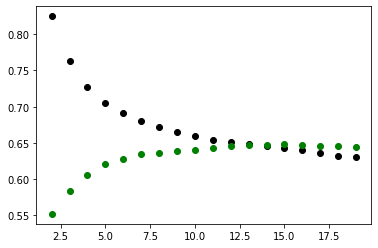

In [66]:
plt.scatter(K, training, color ='k')
plt.scatter(K, test, color ='g')
plt.show()

The above graph and results show that the optimal k value for the 46A line is around 15.


In [67]:
15/line_46A.shape[0]

0.0011517199017199017

In [68]:
knn_46A = KNeighborsRegressor(n_neighbors=15)

In [69]:
knn_46A.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=15)

In [70]:
train_preds = knn_46A.predict(X_train)
train_preds

array([[3048.6       ],
       [4781.        ],
       [4460.2       ],
       ...,
       [4567.73333333],
       [5280.2       ],
       [4932.13333333]])

In [71]:
test_preds = knn_46A.predict(X_test)

In [72]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2605 entries, 190480 to 220260
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   humidity         2605 non-null   int64  
 1   wind_speed       2605 non-null   float64
 2   PLANNEDTIME_DEP  2605 non-null   float64
 3   WEEKDAY          2605 non-null   int64  
 4   MONTH            2605 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 122.1 KB


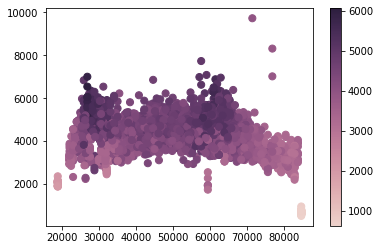

In [73]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(
     X_test.iloc[:,2], y_test.iloc[:,0], c=test_preds, s=50, cmap=cmap)
f.colorbar(points)
plt.show()

## Optimising the model

Using the 46A line as a baseline I will try to optimise the random forest regressor model

In [40]:
line = '46A'
# dataframe containing only rows with current lineid
df_line = df_dir_1[df_dir_1['LINEID'] == line]

# randomly generate sequence based on dataframe index and set to be new index
df_line.set_index(np.random.permutation(df_line.index))
# sort the resulting random index
df_line.sort_index(inplace=True)

# drop unneeded columns
df_line.drop(columns=['LINEID'], inplace=True)

X = df_line.drop(columns=["TRIPTIME"], axis=1)
y = pd.DataFrame(df_line['TRIPTIME'])

# do test train split
# Split the dataset into two datasets: 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

maxdepth = 50
estimators = 50
rfr = RandomForestRegressor(
    oob_score=True, random_state=1, max_depth=maxdepth, n_estimators=estimators)
result = rfr.fit(X_train, y_train)

# save the model to a joblib file
filename = f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/joblibfiles/testing/line_46A_model/dir1/mdepth_{maxdepth}_est_{estimators}.joblib'
joblib.dump(result, open(filename, 'wb'))

In [41]:
rfr_predictions_train = list(rfr.predict(X_train))
rfr_predictions_test = list(rfr.predict(X_test))

# choice of metrics from https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56 and
# https://towardsdatascience.com/random-forest-regression-5f605132d19d
train_mae = metrics.mean_absolute_error(y_train, rfr_predictions_train)
train_mape = metrics.mean_absolute_percentage_error(
    y_train, rfr_predictions_train)
train_mse = metrics.mean_squared_error(
    y_train, rfr_predictions_train) 
train_r2 = metrics.r2_score(y_train, rfr_predictions_train)

test_mae = metrics.mean_absolute_error(y_test, rfr_predictions_test)
test_mape = metrics.mean_absolute_percentage_error(
    y_test, rfr_predictions_test)
test_mse = metrics.mean_squared_error(y_test, rfr_predictions_test)
test_r2 = metrics.r2_score(y_test, rfr_predictions_test)
with open(f'/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/randomforest/joblibfiles/testing/line_46A_model/dir1/mdepth_{maxdepth}_est_{estimators}_metrics.csv', 'w') as file:
    file.write(f'\nTrain metrics for line {line}:'
               f'\nMAE: {train_mae}' +
               f'\nMAPE: {train_mape}' +
               f'\nMSE: {train_mse}' +
               f'\nR2: {train_r2}' +
               f'\nTest metrics for line {line}:'
               f'\nMAE: {test_mae}' +
               f'\nMAPE: {test_mape}' +
               f'\nMSE: {test_mse}' +
               f'\nR2: {test_r2}')


In [42]:
print(f"Max depth: {maxdepth}, n_estimators: {estimators}\n")
print("============Train metrics=============")
print("MAE:", train_mae)
print("MAPE:", train_mape)
print("MSE:", train_mse)
print("R2:", train_r2)

print("============Test metrics=============")
print("MAE:", test_mae)
print("MAPE:", test_mape)
print("MSE:", test_mse)
print("R2:", test_r2)


Max depth: 50, n_estimators: 50

============Train metrics=============
MAE: 142.53860739537203
MAPE: 0.03894917353027954
MSE: 43467.40280859913
R2: 0.944631893410196
============Test metrics=============
MAE: 361.7573428023033
MAPE: 0.0873236814509918
MSE: 245187.02591134116
R2: 0.7121448620869577


We can see the lines with less than 5 rows are 41D and 33E. We will therefore omit these lines from modelling.
- Optimal max_depth = 50, n_estimators=50, file size 40.9MB

# Direction 2
Remembering from <i>feature_pairwise_interactions.ipynb</i> the following:
* categorical_med_info_gain = ['heavy_precip']
* categorical_high_info_gain = ['HOUR','WEEKDAY','MONTH']

## Test-train-split

In [43]:
df_dir_2 = pd.read_csv(
    '/Users/rebeccadillon/git/dublin-bus-team-5/machinelearning/data/modelling/modelling_ready_dir2.csv')

In [44]:
df_dir_2.columns

Index(['humidity', 'wind_speed', 'weather_id', 'heavy_precip', 'HOUR',
       'LINEID', 'PLANNEDTIME_DEP', 'TRIPTIME', 'WEEKDAY', 'MONTH'],
      dtype='object')

Began model creation for Direction 2 by dropping poor performing features from the dataframe as these feature were dropped from direction 1's modelling.

In [45]:
df_dir_2 = df_dir_2.drop(
    columns=['heavy_precip','HOUR','weather_id'])


Perform test-train-split

In [46]:
return_func_2 = train_test_dicts(df_dir_2)

Not enough values for line 41D


In [47]:
lines_dir = return_func_2[0]
X_train_dict = return_func_2[1]
y_train_dict = return_func_2[2]
X_test_dict = return_func_2[3]
y_test_dict = return_func_2[4]

## Run the Algorithm

### Random Forest

In [48]:
rf_model_dict = get_rfr_model_dict(2,lines_dir, X_train_dict, y_train_dict)

Line 1
Line 102
Line 104
Line 11
Line 111
Line 114
Line 116
Line 118
Line 120
Line 122
Line 123
Line 13
Line 130
Line 14
Line 140
Line 142
Line 145
Line 14C
Line 15
Line 150
Line 151
Line 15A
Line 15B
Line 15D
Line 16
Line 161
Line 16C
Line 17
Line 17A
Line 18
Line 184
Line 185
Line 220
Line 236
Line 238
Line 239
Line 25
Line 25A
Line 25B
Line 25D
Line 25X
Line 26
Line 27
Line 270
Line 27A
Line 27B
Line 27X
Line 29A
Line 31
Line 31A
Line 31B
Line 31D
Line 32
Line 32X
Line 33
Line 33A
Line 33B
Line 33D
Line 33X
Line 37
Line 38
Line 38A
Line 38B
Line 38D
Line 39
Line 39A
Line 39X
Line 4
Line 40
Line 40B
Line 40D
Line 40E
Line 41
Line 41A
Line 41B
Line 41C
Line 41X
Line 42
Line 42D
Line 43
Line 44
Line 44B
Line 45A
Line 46A
Line 46E
Line 47
Line 49
Line 51D
Line 51X
Line 53
Line 54A
Line 56A
Line 59
Line 61
Line 63
Line 65
Line 65B
Line 66
Line 66A
Line 66B
Line 66X
Line 67
Line 67X
Line 68
Line 68A
Line 68X
Line 69
Line 69X
Line 7
Line 70
Line 70D
Line 75
Line 76
Line 76A
Line 77A
Line 7

In [49]:
rf_metric_list = get_rf_metric_lists(2, lines_dir, rf_model_dict, X_train_dict, y_train_dict, X_test_dict, y_test_dict)

Test MAE for line 1: 303.62296
Test R2 for line 1: 0.73406
Test MAE for line 102: 276.68754
Test R2 for line 102: 0.68608
Test MAE for line 104: 277.67636
Test R2 for line 104: 0.27758
Test MAE for line 11: 355.83095
Test R2 for line 11: 0.74026
Test MAE for line 111: 346.57955
Test R2 for line 111: 0.69008
Test MAE for line 114: 200.79375
Test R2 for line 114: 0.62084
Test MAE for line 116: 638.85111
Test R2 for line 116: 0.08176
Test MAE for line 118: 608.744
Test R2 for line 118: -0.05954
Test MAE for line 120: 170.11911
Test R2 for line 120: 0.76916
Test MAE for line 122: 303.64531
Test R2 for line 122: 0.7304
Test MAE for line 123: 314.19523
Test R2 for line 123: 0.59103
Test MAE for line 13: 467.66676
Test R2 for line 13: 0.65642
Test MAE for line 130: 193.64995
Test R2 for line 130: 0.4577
Test MAE for line 14: 460.10735
Test R2 for line 14: 0.52191
Test MAE for line 140: 441.66977
Test R2 for line 140: 0.48206
Test MAE for line 142: 193.43552
Test R2 for line 142: 0.98595
Test 

In [50]:
rf_train_metric_list = rf_metric_list[0][0]
rf_test_metric_list = rf_metric_list[1][0]

In [51]:
print("RFR")
print_metrics(lines_dir, rf_train_metric_list, rf_test_metric_list)

RFR
============Train metrics=============
Mean MAE: 126.01368
Mean MAPE: 0.03651
Mean RMSE: 179.07538
Mean R2: 0.92424
============Test metrics=============
Mean MAE: 338.26357
Mean MAPE: 0.09758
Mean RMSE: 462.80683
Mean R2: 0.43373


In [52]:
importance = pd.DataFrame(
    {'feature': X_train_dict['59'].columns, 'importance': rf_model_dict['59'].feature_importances_})
importance.sort_values('importance', ascending=False)


,feature,importance
2,PLANNEDTIME_DEP,0.479159
0,humidity,0.163277
1,wind_speed,0.154712
4,MONTH,0.107366
3,WEEKDAY,0.095486
